In [3]:
import control_utils
import controllers
import polytope
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import uncertainty_utils

## Setup Experiments

In [4]:
# Dynamics
A_true = np.array([[1,.2],[0,1]])
B_true = np.array([0,1]).reshape((2,1))
n = A_true.shape[0]
m = B_true.shape[1]
C_true = np.zeros(n)
x_init = np.array([2.7, 2])
state_limits = polytope.box2poly([[-4, 4],[-3, 3]])
input_limits = polytope.box2poly([[-2, 2]])

# LQR Cost:
Q = np.eye(n)
R = np.eye(m)

# Noise and Disturbances
process_noise_var = 1e-3
process_noise = process_noise_var * np.eye(n)
t = uncertainty_utils.calc_t(0.95, n)
disturbance_set = uncertainty_utils.get_elipse(t, process_noise, np.zeros(n))
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db],[-db, db]])

# Experiment Details
episode_length = 20
controller_horizon = 5
state_reference = np.zeros(n)
state_constraints = (state_limits.A, state_limits.b)
input_constraints = (input_limits.A, input_limits.b)

def sim_traj(A, B, controller, x_init, N=episode_length, process_noise=np.zeros((n,n)), input_limits=np.array([-1e9, 1e9])):
    x_traj = [x_init]
    u_traj = []
    
    x_pred_trajs = []
    u_pred_trajs = []

    for _ in tqdm.tqdm(range(N)):
        u_command = controller.solve(x_traj[-1])
        if u_command is None:
            print("controller error at iteration %d" %_)
            break
        u = np.minimum(np.maximum(input_limits[0], u_command), input_limits[1])
        x_next = A @ x_traj[-1] + B @ u + np.random.multivariate_normal(np.zeros(x_init.shape[0]), process_noise)

        x_traj.append(x_next)
        u_traj.append(u)
        
        x_pred_trajs.append(controller.x_traj.value.T)
        u_pred_trajs.append(controller.u_traj.value.T)
        
    return np.array(x_traj), np.array(u_traj), x_pred_trajs, u_pred_trajs

## Visualize Disturbance Sets

Text(0.5,1,'Disturbance Set')

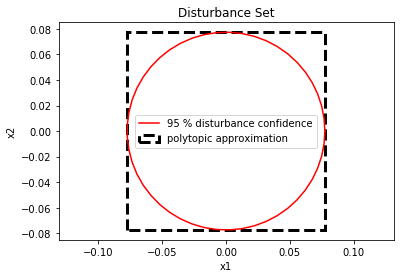

In [5]:
plt.figure()
ax = plt.gca()
plt.axis("equal")
plt.plot(disturbance_set[:,0], disturbance_set[:,1], color="r")
disturbance_bound.plot(ax=ax, alpha=1, color="w", edgecolor="k")
plt.legend(("95 % disturbance confidence", "polytopic approximation"))
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Disturbance Set")

## Tracking MPC

In [6]:
controller = controllers.LTI_MPC_Tracker(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints)
controller.build()

In [7]:
x_init_traj, u_init_traj, x_init_preds, u_init_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.69it/s]


(-3, 3)

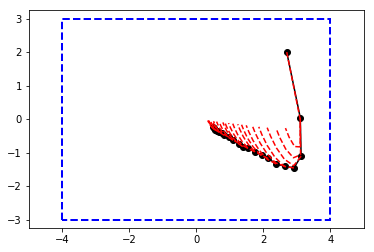

In [8]:
alpha = 1
lw = 2
xlims = (-5,5)
ylims = (-3,3)

plt.figure()
plt.axis("equal")
ax = plt.gca()

plt.plot(x_init_traj[:,0], x_init_traj[:,1], "k-o")
for x_pred in x_init_preds:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")
state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

## MPC

In [9]:
controller = controllers.LTI_MPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints)
controller.build()

In [10]:
x_mpc_traj, u_mpc_traj, x_mpc_preds, u_mpc_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.35it/s]


(-3, 3)

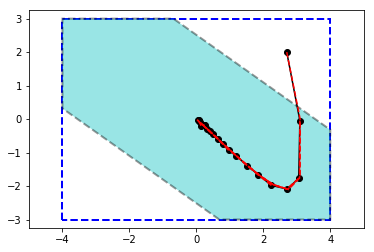

In [11]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

plt.plot(x_mpc_traj[:,0], x_mpc_traj[:,1], "k-o")
for x_pred in x_mpc_preds:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")

X_terminal = polytope.Polytope(*controller.terminal_constraint)
state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)
X_terminal.plot(ax=ax, alpha=.4, color="c", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

## Tube MPC

In [12]:
controller = controllers.LTI_Tube_MPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints)
controller.build((disturbance_bound.A, disturbance_bound.b))

In [13]:
x_tube_traj, u_tube_traj, x_tube_preds, u_tube_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.64it/s]


(-3, 3)

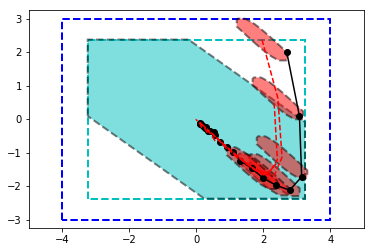

In [14]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)
X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

plt.plot(x_tube_traj[:,0], x_tube_traj[:,1], "k-o")
for x_pred in x_tube_preds:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")

X_terminal = polytope.Polytope(*controller.terminal_constraint)
M = polytope.Polytope(*controller.init_constraint)

X_terminal.plot(ax=ax, alpha=0.5, color="c", linewidth=lw)

for x in np.rollaxis(x_tube_preds[0], 0):
    Mx = control_utils.poly_translate(M, x)
    Mx.plot(ax=ax, alpha=.5, color="r", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

## Learning MPC

In [15]:
num_episodes = 5
controller = controllers.LTI_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [16]:
for episode in range(num_episodes):
#     print(episode)
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.94it/s]


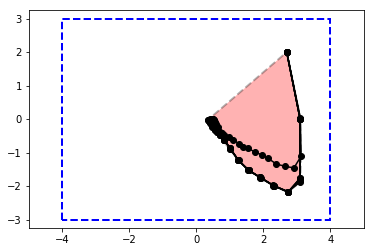

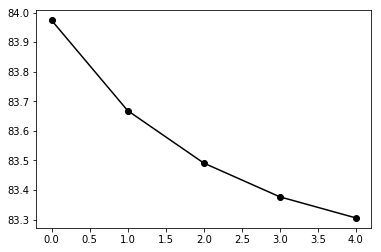

In [17]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")

SS = polytope.qhull(controller.safe_set.value.T)
state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)
SS.plot(ax=ax, alpha=0.3, color="r", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[1:]], "ko-")

## Tube LMPC

In [18]:
num_episodes = 5
w = (disturbance_bound.A, disturbance_bound.b)
controller = controllers.LTI_Tube_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints, w)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
x_nominal, u_nominal = control_utils.compute_nominal_traj(x_mpc_traj.T, u_mpc_traj.T, A_true, B_true, C_true, controller.K)
value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [19]:
true_costs = []
true_trajs = []
for episode in range(num_episodes):
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A_true, B_true, C_true, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
    true_costs.append(control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h))
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)
    true_trajs.append(x_traj)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.75it/s]


(12, 2)
(35, 2)


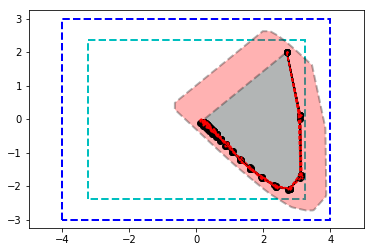

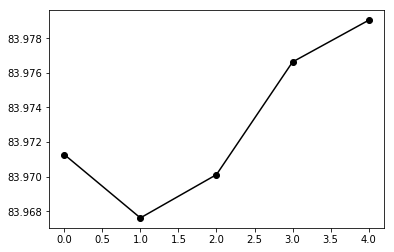

In [20]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

SS = polytope.qhull(controller.safe_set.value.T)
M = polytope.Polytope(*controller.init_constraint)
RSS = control_utils.minkowski_sum(SS, M)
print(SS.A.shape)
print(M.A.shape)
RSS.plot(ax=ax, alpha=0.3, color="r", linewidth=lw)
SS.plot(ax=ax, alpha=0.3, color="c", linewidth=lw)
for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")
    

for x_traj in true_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "r--o", lw=1, markersize=1)
    
plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[1:]], "ko-")
# plt.plot([q[0] for q in true_costs], "ro-")

## Robust LMPC

In [21]:
num_episodes = 5
w = (disturbance_bound.A, disturbance_bound.b)
controller = controllers.LTI_Robust_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints, w)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
x_nominal, u_nominal = control_utils.compute_nominal_traj(x_mpc_traj.T, u_mpc_traj.T, A_true, B_true, C_true, controller.K)
value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [22]:
true_costs = []
true_trajs = []
for episode in range(num_episodes):
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A_true, B_true, C_true, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
    true_costs.append(control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h))
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)
    true_trajs.append(x_traj)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.97it/s]


(13, 2)
(35, 2)


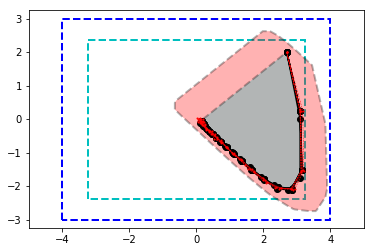

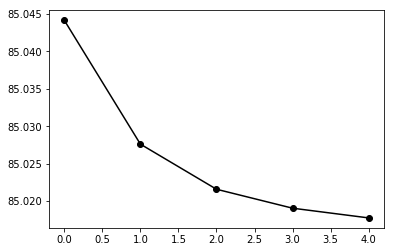

In [23]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

SS = polytope.qhull(controller.safe_set.value.T)
M = polytope.Polytope(*controller.minimal_invariant)
print(SS.A.shape)
print(M.A.shape)
RSS = control_utils.minkowski_sum(SS, M)

RSS.plot(ax=ax, alpha=0.3, color="r", linewidth=lw)
SS.plot(ax=ax, alpha=0.3, color="c", linewidth=lw)
for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")
    
for x_traj in true_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "r--o", lw=.5, markersize=1)
    
plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[1:]], "ko-")
# plt.plot([q[0] for q in true_costs], "ro-")
# plt.ylim((82,86))

## Robust Stochastic LMPC

In [29]:
num_episodes = 5
Sigma = process_noise * t ** 2
controller = controllers.LTI_Stochastic_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints, Sigma)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
x_nominal, u_nominal = control_utils.compute_nominal_traj(x_tube_traj.T, u_tube_traj.T, A_true, B_true, C_true, controller.K)
value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [30]:
true_costs = []
true_trajs = []
for episode in range(num_episodes):
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A_true, B_true, C_true, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
    true_costs.append(control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h))
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)
    true_trajs.append(x_traj)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.05it/s]


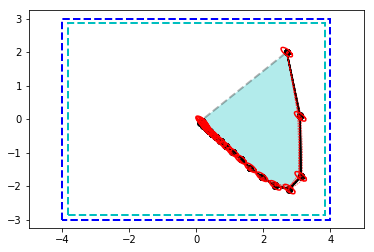

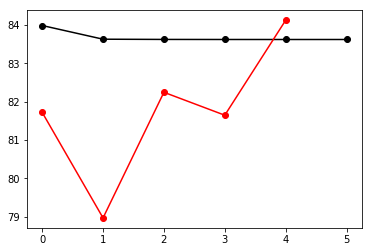

In [32]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

SS = polytope.qhull(controller.safe_set.value.T)
# M = polytope.Polytope(*controller.minimal_invariant)

SS.plot(ax=ax, alpha=0.3, color="c", linewidth=lw)
for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")
    
for x_traj in true_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "r--o", lw=.5, markersize=1)

terminal_cov = controller.minimal_invariant_covariance / (t ** 2)
elipses = uncertainty_utils.get_elipses(t, [terminal_cov] * episode_length, controller.traj_list[-1].T)
for elipse in elipses:
    plt.plot(elipse[:,0], elipse[:,1], "r")

plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[:]], "ko-")
plt.plot([q[0] for q in true_costs], "ro-")
# plt.ylim((82,86))

(-1, 1)

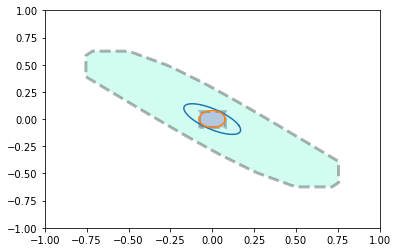

In [27]:
terminal_cov = controller.minimal_invariant_covariance / (t ** 2)
plt.figure()
ax = plt.gca()
terminal_set_boundary = uncertainty_utils.get_elipse(t, terminal_cov, np.zeros(n))
plt.plot(terminal_set_boundary[:,0], terminal_set_boundary[:,1])
plt.plot(disturbance_set[:,0], disturbance_set[:,1])
disturbance_bound.plot(ax=ax, alpha=0.3)
M.plot(ax=ax, alpha=0.3)
plt.xlim((-1,1))
plt.ylim((-1,1))

0.95
